In [ ]:
!pip install opendatasets
!pip install split-folders

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: schwingling
Your Kaggle Key: ··········


100%|██████████| 1.52G/1.52G [00:45<00:00, 35.8MB/s]


In [ ]:
!mv /content/melanoma-cancer-dataset/test/Benign/* /content/melanoma-cancer-dataset/Benign
!mv /content/melanoma-cancer-dataset/test/Malignant/* /content/melanoma-cancer-dataset/Malignant
!mv /content/melanoma-cancer-dataset/train/Benign/* /content/melanoma-cancer-dataset/Benign
!mv /content/melanoma-cancer-dataset/train/Malignant/* /content/melanoma-cancer-dataset/Malignant
!rm -r /content/melanoma-cancer-dataset/test
!rm -r /content/melanoma-cancer-dataset/train

In [ ]:
!mv /content/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/* /content/ct-kidney-dataset-normal-cyst-tumor-and-stone

In [ ]:
import splitfolders
splitfolders.ratio('/content/ct-kidney-dataset-normal-cyst-tumor-and-stone', output="output", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 12446 files [00:06, 1869.70 files/s]


In [ ]:
!rm -r /content/output/val/.ipynb_checkpoints
!rm -r /content/output/train/.ipynb_checkpoints
!rm -r /content/output/test/.ipynb_checkpoints

In [115]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Dense, Dropout, Input, Multiply, Reshape, MaxPooling2D, Conv2D, Add, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime



CONFIG = {
    'INPUT_IMAGE_SIZE': (102, 102),
    'LEARNING_RATE': 0.001,
    'NUM_CLASSES': 4,
    'L2_REGULARIZATION': 0.01,
    'TRAIN_BATCH_SIZE': 128,
    'TEST_BATCH_SIZE': 128,
    'EPOCHS': 25,
}

In [116]:

def load_data(train_dir, test_dir, img_size, train_batch_size, test_batch_size):

    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        color_mode='rgb',
        batch_size=train_batch_size,
        class_mode='categorical',
        shuffle=True
    )

    test_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        color_mode='rgb',
        batch_size=test_batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_data, test_data

train_dir = '/content/output/train'
test_dir = '/content/output/test'

train_data, test_data = load_data(
    train_dir,
    test_dir,
    img_size=CONFIG['INPUT_IMAGE_SIZE'],
    train_batch_size=CONFIG['TRAIN_BATCH_SIZE'],
    test_batch_size=CONFIG['TEST_BATCH_SIZE']
)
train_data.class_indices

Found 9955 images belonging to 4 classes.
Found 1249 images belonging to 4 classes.


{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}

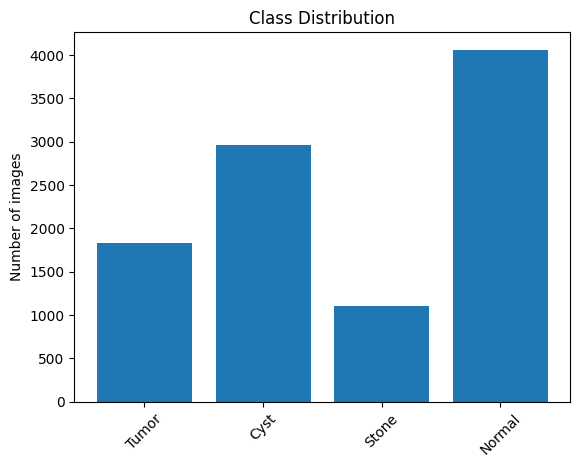

{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}

In [117]:

def plot_class_distribution(train_dir):
    class_counts = {}
    for root, dirs, files in os.walk(train_dir):
        labels = [d for d in dirs if os.path.isdir(os.path.join(root, d))]
        if labels:
            break

    for label in labels:
        path = os.path.join(train_dir, label)
        class_counts[label] = len(os.listdir(path))

    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.ylabel('Number of images')
    plt.show()


plot_class_distribution(train_dir)

train_data.class_indices

In [118]:

class XceptionLayer(Layer):
    def __init__(self, input_shape, **kwargs):
        super(XceptionLayer, self).__init__(**kwargs)
        self.xception = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

    def call(self, inputs):
        return self.xception(inputs)

In [119]:
# CBAM layer
class CBAMLayer(Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(CBAMLayer, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Channel Attention
        self.channel_avg_pool = GlobalAveragePooling2D()
        self.channel_max_pool = MaxPooling2D()
        self.channel_dense_1 = Dense(input_shape[-1] // self.reduction_ratio, activation='relu')
        self.channel_dense_2 = Dense(input_shape[-1], activation='softmax')

        # Spatial Attention
        self.spatial_conv = Conv2D(1, kernel_size=(7, 7), padding='same', activation='softmax')

    def call(self, inputs):
        # Channel attention
        channel_avg_pool = self.channel_avg_pool(inputs)
        channel_max_pool = self.channel_max_pool(inputs)
        channel_avg_pool = Reshape((1, 1, -1))(channel_avg_pool)
        channel_max_pool = Reshape((1, 1, -1))(channel_max_pool)
        channel_avg_pool = self.channel_dense_1(channel_avg_pool)
        channel_max_pool = self.channel_dense_1(channel_max_pool)
        channel_avg_pool = self.channel_dense_2(channel_avg_pool)
        channel_max_pool = self.channel_dense_2(channel_max_pool)
        channel_attention = Add()([channel_avg_pool, channel_max_pool])
        channel_attention = Multiply()([inputs, channel_attention])

        # Spatial attention
        avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_attention)
        max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_attention)
        concat = Concatenate(axis=-1)([avg_pool, max_pool])
        spatial_attention = self.spatial_conv(concat)
        spatial_attention = Multiply()([channel_attention, spatial_attention])

        return spatial_attention

In [120]:
from keras.metrics import AUC,Precision,Recall
def create_transfer_model(input_shape, num_classes, l2_reg=CONFIG['L2_REGULARIZATION']):
    inputs = Input(shape=input_shape)
    x = XceptionLayer(input_shape)(inputs)
    x.trainable = False

    x = CBAMLayer()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(2048, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg))(x)

    model = Model(inputs=inputs, outputs=outputs)

    optimizer = Adam(learning_rate=CONFIG['LEARNING_RATE'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',AUC(),Precision(),Recall()])

    return model


model = create_transfer_model(input_shape=(*CONFIG['INPUT_IMAGE_SIZE'], 3), num_classes=CONFIG['NUM_CLASSES'])
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_54 (InputLayer)       [(None, 102, 102, 3)]     0         
                                                                 
 xception_layer_27 (Xceptio  (None, 3, 3, 2048)        20861480  
 nLayer)                                                         
                                                                 
 cbam_layer_21 (CBAMLayer)   (None, 3, 3, 2048)        526563    
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_20 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0  

In [121]:
# Function to train and evaluate the model
def train_and_evaluate_model(model, train_data, test_data, epochs):
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=test_data,
        verbose=1
    )
    return history

history = train_and_evaluate_model(model, train_data, test_data, CONFIG['EPOCHS'])

Epoch 1/25
78/78 [==============================] - 81s 751ms/step - loss: 4.0036 - accuracy: 0.4980 - auc_10: 0.7586 - precision_10: 0.9052 - recall_10: 0.2034 - val_loss: 1.7467 - val_accuracy: 0.5604 - val_auc_10: 0.7503 - val_precision_10: 0.5792 - val_recall_10: 0.3923
Epoch 2/25
78/78 [==============================] - 57s 728ms/step - loss: 0.8773 - accuracy: 0.6784 - auc_10: 0.8881 - precision_10: 0.8275 - recall_10: 0.4448 - val_loss: 1.8034 - val_accuracy: 0.6245 - val_auc_10: 0.7980 - val_precision_10: 0.6254 - val_recall_10: 0.6229
Epoch 3/25
78/78 [==============================] - 57s 729ms/step - loss: 0.8007 - accuracy: 0.6987 - auc_10: 0.9072 - precision_10: 0.7568 - recall_10: 0.5902 - val_loss: 1.2271 - val_accuracy: 0.6205 - val_auc_10: 0.8166 - val_precision_10: 0.6660 - val_recall_10: 0.5556
Epoch 4/25
78/78 [==============================] - 58s 751ms/step - loss: 0.7458 - accuracy: 0.7113 - auc_10: 0.9162 - precision_10: 0.7562 - recall_10: 0.6138 - val_loss: 0.

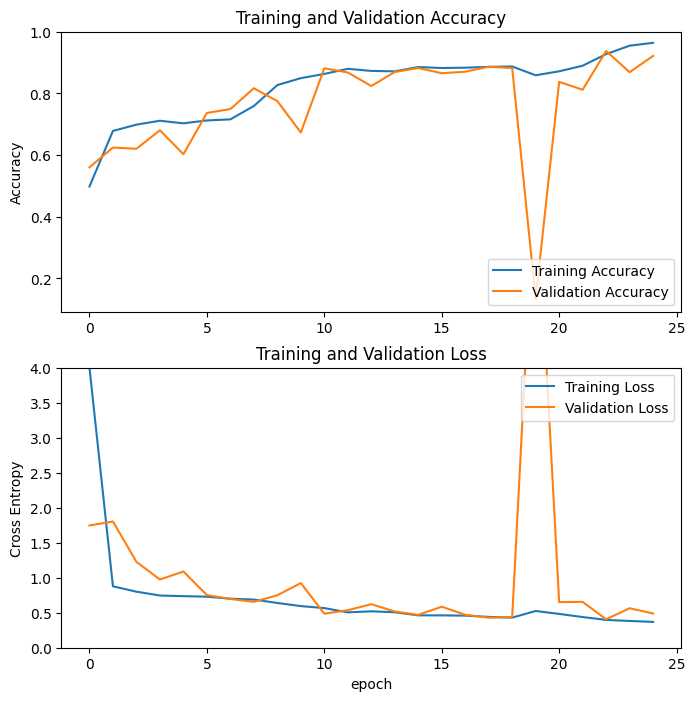

In [122]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [126]:
model.save_weights('./checkpoints/my_checkpoint')

In [123]:
test_score=model.evaluate(test_data)

10/10 [==============================] - 4s 379ms/step - loss: 0.4887 - accuracy: 0.9215 - auc_10: 0.9798 - precision_10: 0.9226 - recall_10: 0.9159


In [128]:
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_data = val_datagen.flow_from_directory(
        '/content/output/val',
        target_size=(102,102),
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

Found 1242 images belonging to 4 classes.


<ipython-input-134-62570569ffe4>:45: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_data)


Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

        Cyst       0.93      0.92      0.92       372
      Normal       1.00      0.95      0.97       509
       Stone       0.91      0.71      0.79       139
       Tumor       0.79      1.00      0.88       229

    accuracy                           0.92      1249
   macro avg       0.91      0.89      0.89      1249
weighted avg       0.93      0.92      0.92      1249



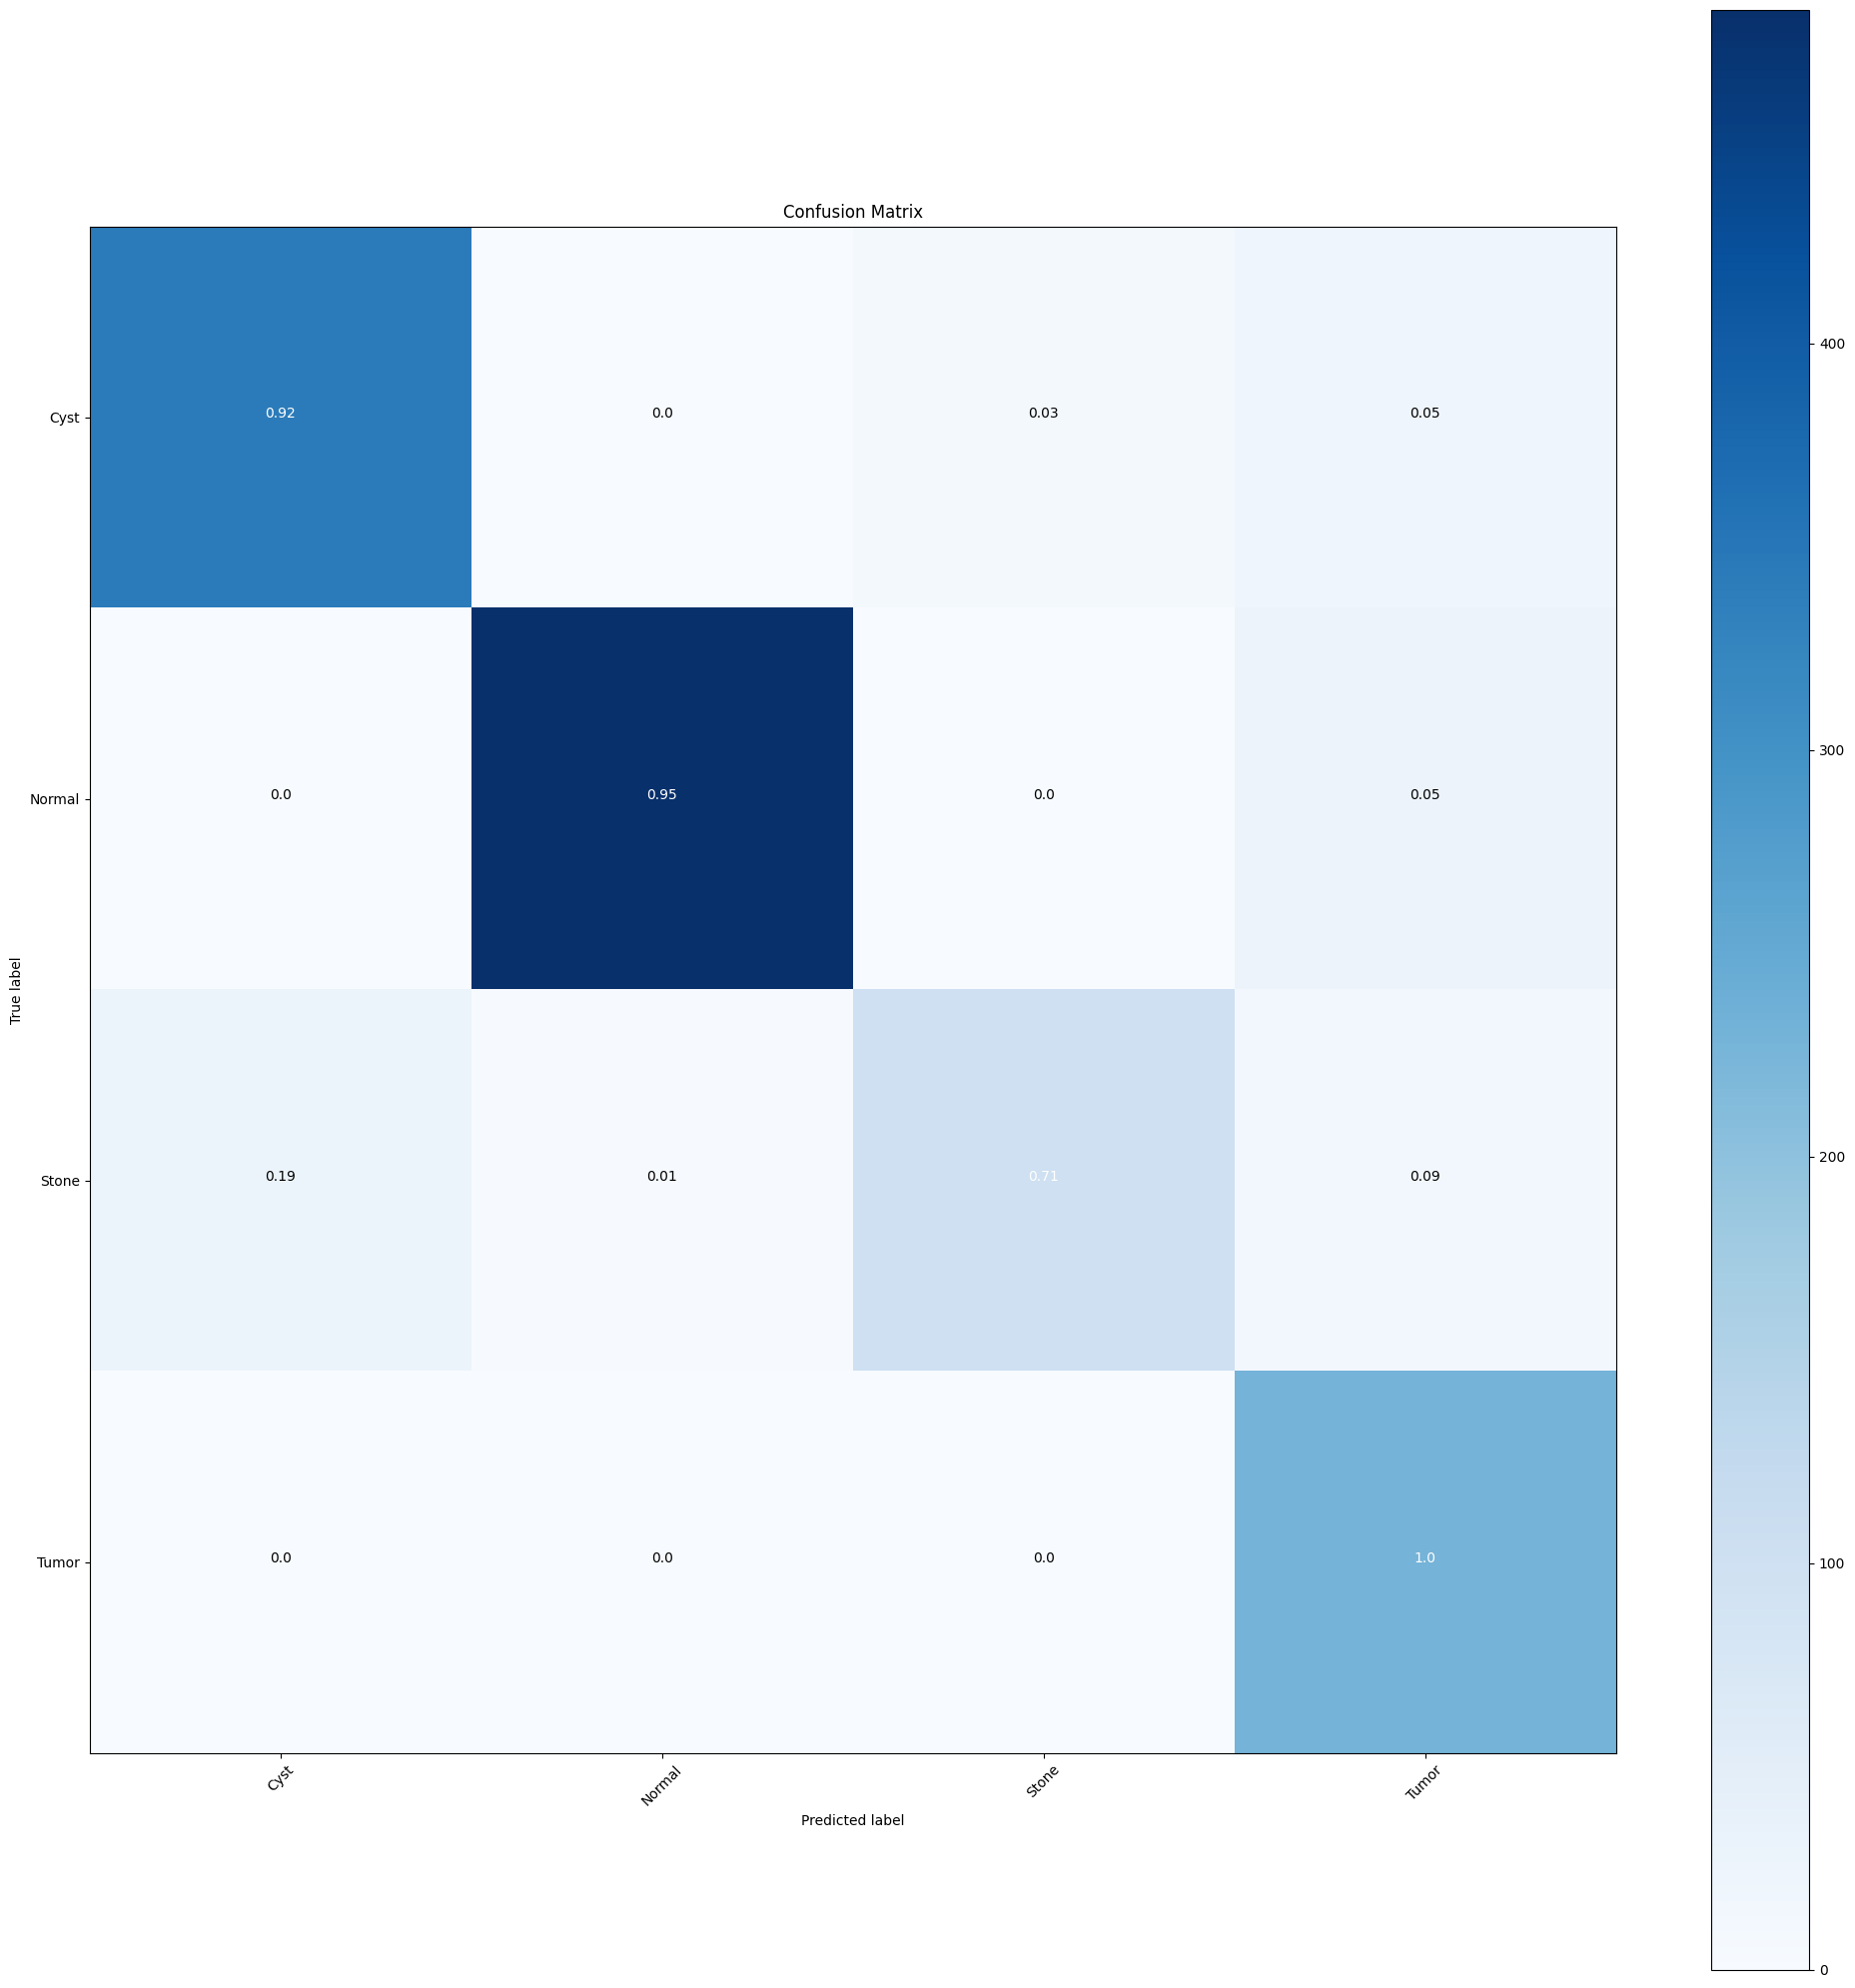

In [134]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools
#shuffle=False

target_names = []
for key in train_data.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix

Y_pred = model.predict_generator(test_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_data.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(test_data.classes, y_pred, target_names=target_names))